<a target="_blank" href="https://colab.research.google.com/github/ZHAW-ZAV/TSO-FS25-students/blob/main/09_qpa/09_02_qpa2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import random
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm
import itertools
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive

    # Download the TSO environment
    drive.mount("/content/drive")
    shared_file = "1fuyEnXBRBZJ1O2ijOLx4ms-L4si430RJ"
    !gdown "https://drive.google.com/uc?id={shared_file}" -O tso-env.zip

    !unzip tso-env.zip -d /content | tqdm > /dev/null

    !source /content/tso-env/bin/activate

    sys.path.append("/content/tso-env/lib/python3.11/site-packages/")


Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1fuyEnXBRBZJ1O2ijOLx4ms-L4si430RJ
From (redirected): https://drive.google.com/uc?id=1fuyEnXBRBZJ1O2ijOLx4ms-L4si430RJ&confirm=t&uuid=e53e01fb-df3f-49b9-a910-7406f4fdf3c2
To: /content/tso-env.zip
100% 362M/362M [00:04<00:00, 88.6MB/s]
27659it [00:16, 1686.73it/s]


In [2]:
import simpy

The code above loads the data, do not modify.

***

# TSO Semester Week 10: Quantitative Process Analysis

This exercise deals with the topic of quantitative process analysis using the example of a security check in a fictitious airport terminal. Use the DES simulation model of an M/M/c queueing system provided below for this exercise.

This exercise focusses on the following topics:
* PART A: You will deal with the topics transient vs. steady state of a DES simulation model. You will also compare the steady-state results with those of an analytical queuing model (which you are familiar with from the INFRA-AD module).
* PART B: You will analyse the influence of initial conditions on the results of a DES simulation model (especially on the transition between the transient and the steady state).
* PART C: You carry out a $2^k$ factorial analysis.

Note that this exercise is based on the chapters *Analyzing Outputs of DES Simulations* and *Experimental Design* of the **TSO Quantitative Process Analysis Script**.

***
## PART A: Transient vs. Steady-State
Below you will find the software code for a DES simulation of an M/M/c queueing system. The DES model is parameterised via the global variables in the *Parametrisation of Simulation Model* block. The simulation results for the delays experienced by the passengers (i.e. waiting times in the queue) can be found in the dataframe `df_delays`. The resulting queue lengths can be found in the dataframe `df_queue_lengths`.

Use the DES simulation model of an M/M/c queueing system provided below with the specified parameters for the following tasks:
1. Create a plot showing the delay experienced by the passengers vs. the passenger index. Plot the average delay, the 10th, 25th, 75th, and 90th percentile.
2. Based on the plot created from Task 1, determine the transient phase (warm-up) and the steady-state phase.
3. Compare the average delay in the steady-state with the results of an analytical model for an M/M/c queueing system. Information on the analytical model of an M/M/c system can be found in the INFRA-AD documents (e.g., see video [*Queueing System Models*](https://zhaw.mediaspace.cast.switch.ch/media/t/0_4x5ixao3/7740?)).

In [3]:
# Simulation parameters
C = 2                   # Number of Servers
ARRIVAL_RATE = 1        # Lambda: Average number of arrivals per time unit
SERVICE_RATE = 0.55555  # Mu: Average number of services per server per time unit
SIM_TIME = 3000         # Total simulation time
NUM_RUNS = 2000         # Number of independent simulation runs
CUSTOMER_INTERVAL = 20  # Record delays for every 20th customer


# Function to generate interarrival times
def generate_interarrival_time(arrival_rate):
    """Generate interarrival time based on exponential distribution."""
    return random.expovariate(arrival_rate)

# Function to generate service times
def generate_service_time(mean_service_rate):
    """Generate service time based on exponential distribution."""
    return random.expovariate(mean_service_rate)

# Simulation function
def simulate_one_run(customer_interval):
    """Simulate a single M/M/c run and record delays & queue lengths for every `customer_interval` customer."""
    delays = {}
    queue_lengths = {}

    def customer(env, name, server, service_rate):
        """A customer process arriving and waiting for service."""
        arrival_time = env.now

        # Log queue length at arrival
        queue_length_at_arrival = len(server.queue)

        with server.request() as request:
            yield request  # Wait for the server
            wait_time = env.now - arrival_time  # Time spent in queue

            if name % customer_interval == 0:  # Record for every `customer_interval` customer
                delays[name] = wait_time
                queue_lengths[name] = queue_length_at_arrival

            service_time = generate_service_time(service_rate)
            yield env.timeout(service_time)  # Simulate service

    def arrival_process(env, server, arrival_rate, service_rate):
        """Process generating customers according to a Poisson arrival process."""
        customer_id = 0
        while True:
            interarrival_time = generate_interarrival_time(arrival_rate)
            yield env.timeout(interarrival_time)
            customer_id += 1
            env.process(customer(env, customer_id, server, service_rate))

    # Create the simulation environment
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=C)
    env.process(arrival_process(env, server, ARRIVAL_RATE, SERVICE_RATE))
    env.run(until=SIM_TIME)

    return delays, queue_lengths

# Run the simulation NUM_RUNS times and collect data
all_delays = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}
all_queue_lengths = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}

for run in tqdm(range(NUM_RUNS), desc="Running Simulations", unit="run"):
    delays, queue_lengths = simulate_one_run(CUSTOMER_INTERVAL)

    for customer, delay in delays.items():
        if customer in all_delays:
            all_delays[customer].append(delay)

    for customer, queue_length in queue_lengths.items():
        if customer in all_queue_lengths:
            all_queue_lengths[customer].append(queue_length)

# Convert results to DataFrames for analysis
df_delays = pd.DataFrame.from_dict(all_delays, orient="index").T
df_queue_lengths = pd.DataFrame.from_dict(all_queue_lengths, orient="index").T


Running Simulations: 100%|██████████| 2000/2000 [01:48<00:00, 18.48run/s]


In [ ]:
# PART A, Task 1: Plot the delay distribution

In [ ]:
# Part A, Task 2: Warm-up & Steady-State Conditions

In [ ]:
# Part A, Task 3: Comparison with Analytical Queueing System Model

***
## PART B: Examine Influence of Initial Conditions

Below you will find the software code for a DES simulation of an M/M/c queueing system. The DES model is parameterised via the global variables in the *Parametrisation of Simulation Model* block. In PART B of this exercise we investigate the influence of initial conditions on the transient phase of a DES simulation model. To this end, we analyse how the number of passengers being present in the queue of the queueing system at simulation time $t=0$ (see parameter `INITIAL_ENTITIES`) affects the transient phase .

The simulation results are saved in dictionary `results`. For each value in the `INITIAL_ENTITIES` list, which acts as the key of `results`, a dataframe `df_delays` is saved for the delays experienced by the passengers (i.e., waiting times in the queue) and a dataframe `df_queue_lengths` for the resulting queue lengths. For example, if you want to read the results for `INITIAL_ENTITIES = 20`, you can do this as follows `df_delays, df_queue_length = results[20]`.

### Tasks:
1. plot a diagram in which the delays experienced by the passengers are plotted for all analysed values of `INITIAL_ENTITIES` as a function of the passenger index.

In [4]:
# Parametrization of Simulation Model
C = 2                                                   # Number of Servers
ARRIVAL_RATE = 1                                        # Lambda: Average number of arrivals per time unit
SERVICE_RATE = 0.55555                                  # Mu: Average number of services per server per time unit
SIM_TIME = 3000                                         # Total simulation time
NUM_RUNS = 2000                                         # Number of independent simulation runs
CUSTOMER_INTERVAL = 20                                  # Record delays for every 20th customer
INITIAL_ENTITIES = [0, 10, 20, 30, 40, 50]   # Different initial queue lengths

# Function to generate interarrival times
def generate_interarrival_time(arrival_rate):
    """Generate interarrival time based on exponential distribution."""
    return random.expovariate(arrival_rate)

# Function to generate service times
def generate_service_time(mean_service_rate):
    """Generate service time based on exponential distribution."""
    return random.expovariate(mean_service_rate)

# Simulation function
def simulate_one_run(initial_queue, customer_interval):
    """Simulate a single M/M/c run with an initial queue."""
    delays = {}
    queue_lengths = {}

    def initial_queue_process(env, server, initial_queue, service_rate):
        """Populate the system with `initial_queue` customers at the start."""
        for i in range(initial_queue):
            env.process(customer(env, f"Initial-{i}", server, service_rate))
            yield env.timeout(0)  # Ensure proper scheduling

    def customer(env, name, server, service_rate):
        """A customer process arriving and waiting for service."""
        arrival_time = env.now
        queue_length_at_arrival = len(server.queue)  # Log queue length

        with server.request() as request:
            yield request  # Wait for the server
            wait_time = env.now - arrival_time  # Time spent in queue

            if isinstance(name, int) and name % customer_interval == 0:  # Record every `customer_interval` customer
                delays[name] = wait_time
                queue_lengths[name] = queue_length_at_arrival

            service_time = generate_service_time(service_rate)
            yield env.timeout(service_time)  # Simulate service

    def arrival_process(env, server, arrival_rate, service_rate):
        """Process generating customers according to a Poisson arrival process."""
        customer_id = 0
        while True:
            interarrival_time = generate_interarrival_time(arrival_rate)
            yield env.timeout(interarrival_time)
            customer_id += 1
            env.process(customer(env, customer_id, server, service_rate))

    # Create the simulation environment
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=C)

    # Populate initial queue
    env.process(initial_queue_process(env, server, initial_queue, SERVICE_RATE))

    # Start arrival process
    env.process(arrival_process(env, server, ARRIVAL_RATE, SERVICE_RATE))
    env.run(until=SIM_TIME)

    return delays, queue_lengths

# Run the simulation for different initial queue conditions
results = {}
for initial_queue in INITIAL_ENTITIES:
    all_delays = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}
    all_queue_lengths = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}

    # Run simulations with tqdm progress bar
    for _ in tqdm(range(NUM_RUNS), desc=f"Simulating for Initial Queue = {initial_queue}", unit="run"):
        delays, queue_lengths = simulate_one_run(initial_queue, CUSTOMER_INTERVAL)

        for customer, delay in delays.items():
            if customer in all_delays:
                all_delays[customer].append(delay)

        for customer, queue_length in queue_lengths.items():
            if customer in all_queue_lengths:
                all_queue_lengths[customer].append(queue_length)

    results[initial_queue] = (all_delays, all_queue_lengths)

# Convert results to DataFrames for each initial queue condition
converted_results = {}  # Create a new dictionary to store the converted DataFrames

for initial_queue, (delays, queue_lengths) in results.items():
    df_delays = pd.DataFrame.from_dict(delays, orient="index").T
    df_queue_lengths = pd.DataFrame.from_dict(queue_lengths, orient="index").T
    converted_results[initial_queue] = (df_delays, df_queue_lengths)

# If you want to overwrite the original dictionary with the converted DataFrames
results = converted_results

Simulating for Initial Queue = 50: 100%|██████████| 2000/2000 [01:53<00:00, 17.59run/s]


<ipython-input-29-d75dc15a3cfb>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


KeyError: 0

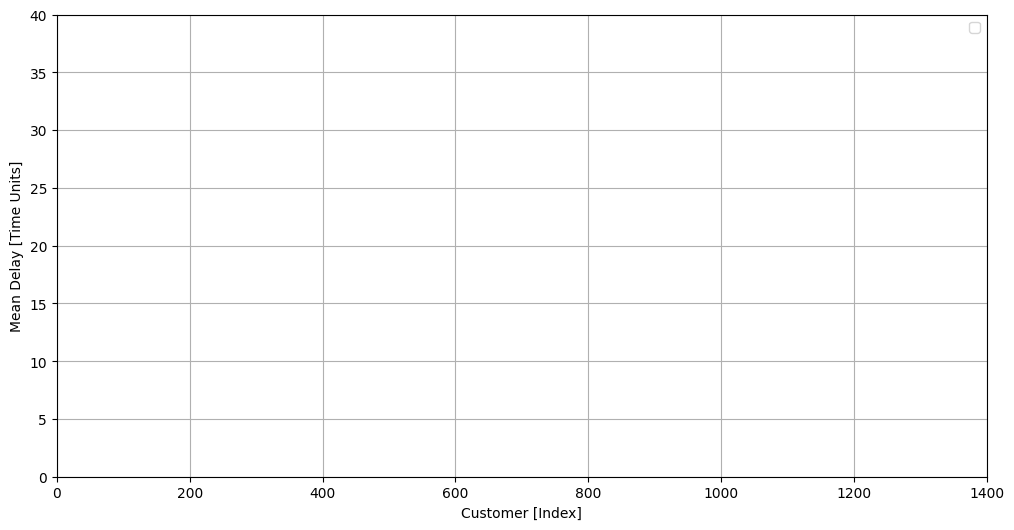

In [29]:
# PART B, TASK 1: Plot of how the initial conditions affect the warm-up period
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.xlabel('Customer [Index]')
plt.ylabel('Mean Delay [Time Units]')
plt.ylim(0, 40)
plt.xlim(0, 1400)
plt.grid()

for i, initial_queue_length in enumerate(INITIAL_ENTITIES):
  initial_queue = str(initial_queue_length)
  df_delays, _ = results[initial_queue]
  mean_delay = df_delays.mean(axis=0)        # per-customer mean (per column)
  plt.plot(mean_delay.index, mean_delay.values)

plt.legend(loc='upper right')
plt.show()

***
## PART C: $2^k$-Factorial Design & Analysis

Carry out a $2^k$ factorial analysis. Use the DES model of an M/M/c queueing system below. We analyse the influence of two **factors**, namely (i) number of servers `SERVERS` and (ii) average service rate of a server `SERVICE_RATES` on the **response** average delay in steady-state conditions. For this purpose, we have defined both factors as vectors, the first element of which describes a low (-) state and the second element the high (+) state. The simulation model below then performs `NUM_RUNS` for all combinations of the two analysed factors and saves the results in dictionary `results`.

### Tasks:
1. Create a plot showing the delay experienced by passengers versus the Passenger Index for all combinations of the two factors.
2. Calculate the responses $R_1, R_2, R_3$ and $R_4$ (i.e. the average delays in steady-state conditions) for all combinations of the factors.
3. Calculate effect size $e_1$ and $e_2$ of the two factors. Interpret the results.

In [28]:
# Simulation parameters
ARRIVAL_RATE = 1.4          # Arrival Rate [passengers per unit time]
SIM_TIME = 3000             # Total simulation time
NUM_RUNS = 5000             # Number of independent simulation runs
CUSTOMER_INTERVAL = 20      # Record delays for every 20th customer

# Factor levels
SERVERS = [3, 4]                      # Factor 1: Number of servers
SERVICE_RATES = [1/1.9, 1/1.6]      # Factor 2: Service rate per server (1/service time)

# Function to generate interarrival times
def generate_interarrival_time(arrival_rate):
    """Generate interarrival time based on exponential distribution."""
    return random.expovariate(arrival_rate)

# Function to generate service times
def generate_service_time(mean_service_rate):
    """Generate service time based on exponential distribution."""
    return random.expovariate(mean_service_rate)

# Simulation function
def simulate_one_run(c, service_rate, customer_interval):
    """Simulate a single M/M/c run with given `c` servers and `service_rate`."""
    delays = {}
    queue_lengths = {}

    def customer(env, name, server, service_rate):
        """A customer process arriving and waiting for service."""
        arrival_time = env.now
        queue_length_at_arrival = len(server.queue)  # Log queue length

        with server.request() as request:
            yield request  # Wait for the server
            wait_time = env.now - arrival_time  # Time spent in queue

            if name % customer_interval == 0:  # Record for every `customer_interval` customer
                delays[name] = wait_time
                queue_lengths[name] = queue_length_at_arrival

            service_time = generate_service_time(service_rate)
            yield env.timeout(service_time)  # Simulate service

    def arrival_process(env, server, arrival_rate, service_rate):
        """Process generating customers according to a Poisson arrival process."""
        customer_id = 0
        while True:
            interarrival_time = generate_interarrival_time(arrival_rate)
            yield env.timeout(interarrival_time)
            customer_id += 1
            env.process(customer(env, customer_id, server, service_rate))

    # Create the simulation environment
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=c)
    env.process(arrival_process(env, server, ARRIVAL_RATE, service_rate))
    env.run(until=SIM_TIME)

    return delays, queue_lengths

# Dictionary to store results for all (SERVERS × SERVICE_RATES) combinations
results = {}

# Run the simulation for all combinations of SERVERS & SERVICE_RATES
for c, service_rate in itertools.product(SERVERS, SERVICE_RATES):
    key = f"Servers={c}, ServiceRate={service_rate:.4f}"  # Unique key for each setting

    all_delays = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}
    all_queue_lengths = {i: [] for i in range(CUSTOMER_INTERVAL, SIM_TIME, CUSTOMER_INTERVAL)}

    # Run simulations with tqdm progress bar
    for _ in tqdm(range(NUM_RUNS), desc=f"Simulating {key}", unit="run"):
        delays, queue_lengths = simulate_one_run(c, service_rate, CUSTOMER_INTERVAL)

        for customer, delay in delays.items():
            if customer in all_delays:
                all_delays[customer].append(delay)

        for customer, queue_length in queue_lengths.items():
            if customer in all_queue_lengths:
                all_queue_lengths[customer].append(queue_length)

    # Store results in dictionary
    results[key] = (
        pd.DataFrame.from_dict(all_delays, orient="index").T,  # Delay DataFrame
        pd.DataFrame.from_dict(all_queue_lengths, orient="index").T  # Queue Length DataFrame
    )

Simulating Servers=4, ServiceRate=0.6250: 100%|██████████| 5000/5000 [06:11<00:00, 13.47run/s]


In [ ]:
# PART C, TASK 1: Plotting the results
idx = 500

plt.figure(figsize=(12,6))

for key, (df_delays, _) in results.items():
  #Extract values from key
  num_servers, service_rate = key.split(", ")
  num_servers = int(num_servers.split("=")[1])
  service_rate = float(service_rate.split("=")[1])

  # Convert column names to integers
  df_delays.columns = df_delays.columns.astype(int)

  # Select only columns where index > idx
  df_delays_steady = df_delays.loc[:, df_delays.columns > idx]

  mean_delay = df_delays.mean(axis=0)

  plt.plot(mean_delay.index, mean_delay.values)
  plt.hlines(df_delays_steady, xmin=mean_delay.index.min(), xmax=mean_delay.index.max(), linestyles='dashed', lw=1)

plt.ylim(0.5)
plt.xlim(0,2000)
plt.xlabel('Customer [Index]')
plt.ylabel('Mean Delay [Time Units]')
plt.grid()
plt.show()

KeyboardInterrupt: 

In [30]:
# PART C, TASK 2: Extracting Responses R1, R2, R3, and R4



SyntaxError: expected ':' (<ipython-input-30-b11fedc45854>, line 2)

In [ ]:
# PART C, TASK 3: Calculate Effect Sizes e1 and e2

